In [1]:
from argparse import ArgumentParser
import os
import sys
import random
import logging
import numpy as np

from scipy import integrate
from sklearn.metrics import mean_squared_error as MSE
import copy

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

import torch
from torch.utils.data import DataLoader

/home/jvarela/venvs/bostonCrime/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import SVG, display
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [3]:
from DeepStpp.plotter import *
from DeepStpp.model import DeepSTPP, log_ft, t_intensity, s_intensity
from DeepStpp.data.dataset import SlidingWindowWrapper
from DeepStpp.util import *

/home/jvarela/Dropbox/software/spatio_temporal_statistical_boston_crime_analysis/bostonCrimeVisualizationOnPath/DeepStpp/model.py:271: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.config.constrain_b is 'tanh':
/home/jvarela/Dropbox/software/spatio_temporal_statistical_boston_crime_analysis/bostonCrimeVisualizationOnPath/DeepStpp/model.py:273: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'sigmoid':
/home/jvarela/Dropbox/software/spatio_temporal_statistical_boston_crime_analysis/bostonCrimeVisualizationOnPath/DeepStpp/model.py:275: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'neg-sigmoid':
/home/jvarela/Dropbox/software/spatio_temporal_statistical_boston_crime_analysis/bostonCrimeVisualizationOnPath/DeepStpp/model.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'softplus':
/home/jvarela/Dropbox/software/spatio_temporal_statistical_b

In [4]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

You are using GPU acceleration.
Device name:  NVIDIA GeForce RTX 4070 Ti SUPER
Number of CUDAs(cores):  1


In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [6]:
"""
Prepare logger
"""
logger = logging.getLogger('full_lookahead{}batch{}'.format(config.lookahead, config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('full_lookahead{}batch{}.log'.format(config.lookahead, config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

# Boston Crimes

In [14]:
# Note these are only the violent crimes
dataset = 'boston_crimes'
npzf = np.load(f'data/processed/{dataset}.npz', allow_pickle=True)

In [15]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)


In [16]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

### Training

In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'models/{dataset}_0.mod')

In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'models/{dataset}_1.mod')

In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'models/{dataset}_2.mod')

### Evaluation

In [23]:
from model import *
model = DeepSTPP(config, device)
model.load_state_dict(torch.load(f'models/{dataset}_2.mod'))

scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[ 0.18335724  0.16269684 62.62074   ]
[-7.1178680e+01  4.2232388e+01  1.9389711e-06]


/tmp/ipykernel_22107/1062837804.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{dataset}_2.mod'))


In [26]:

from DeepStpp.model import calc_lamb

scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
time_to_plot = 168.0
time_to_plot = 168.0
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=time_to_plot, round_time=False)


/home/jvarela/venvs/bostonCrime/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Intensity time range : 168.0


100%|██████████| 200/200 [00:00<00:00, 371.62it/s]


Inferred cmax: 747.6328125


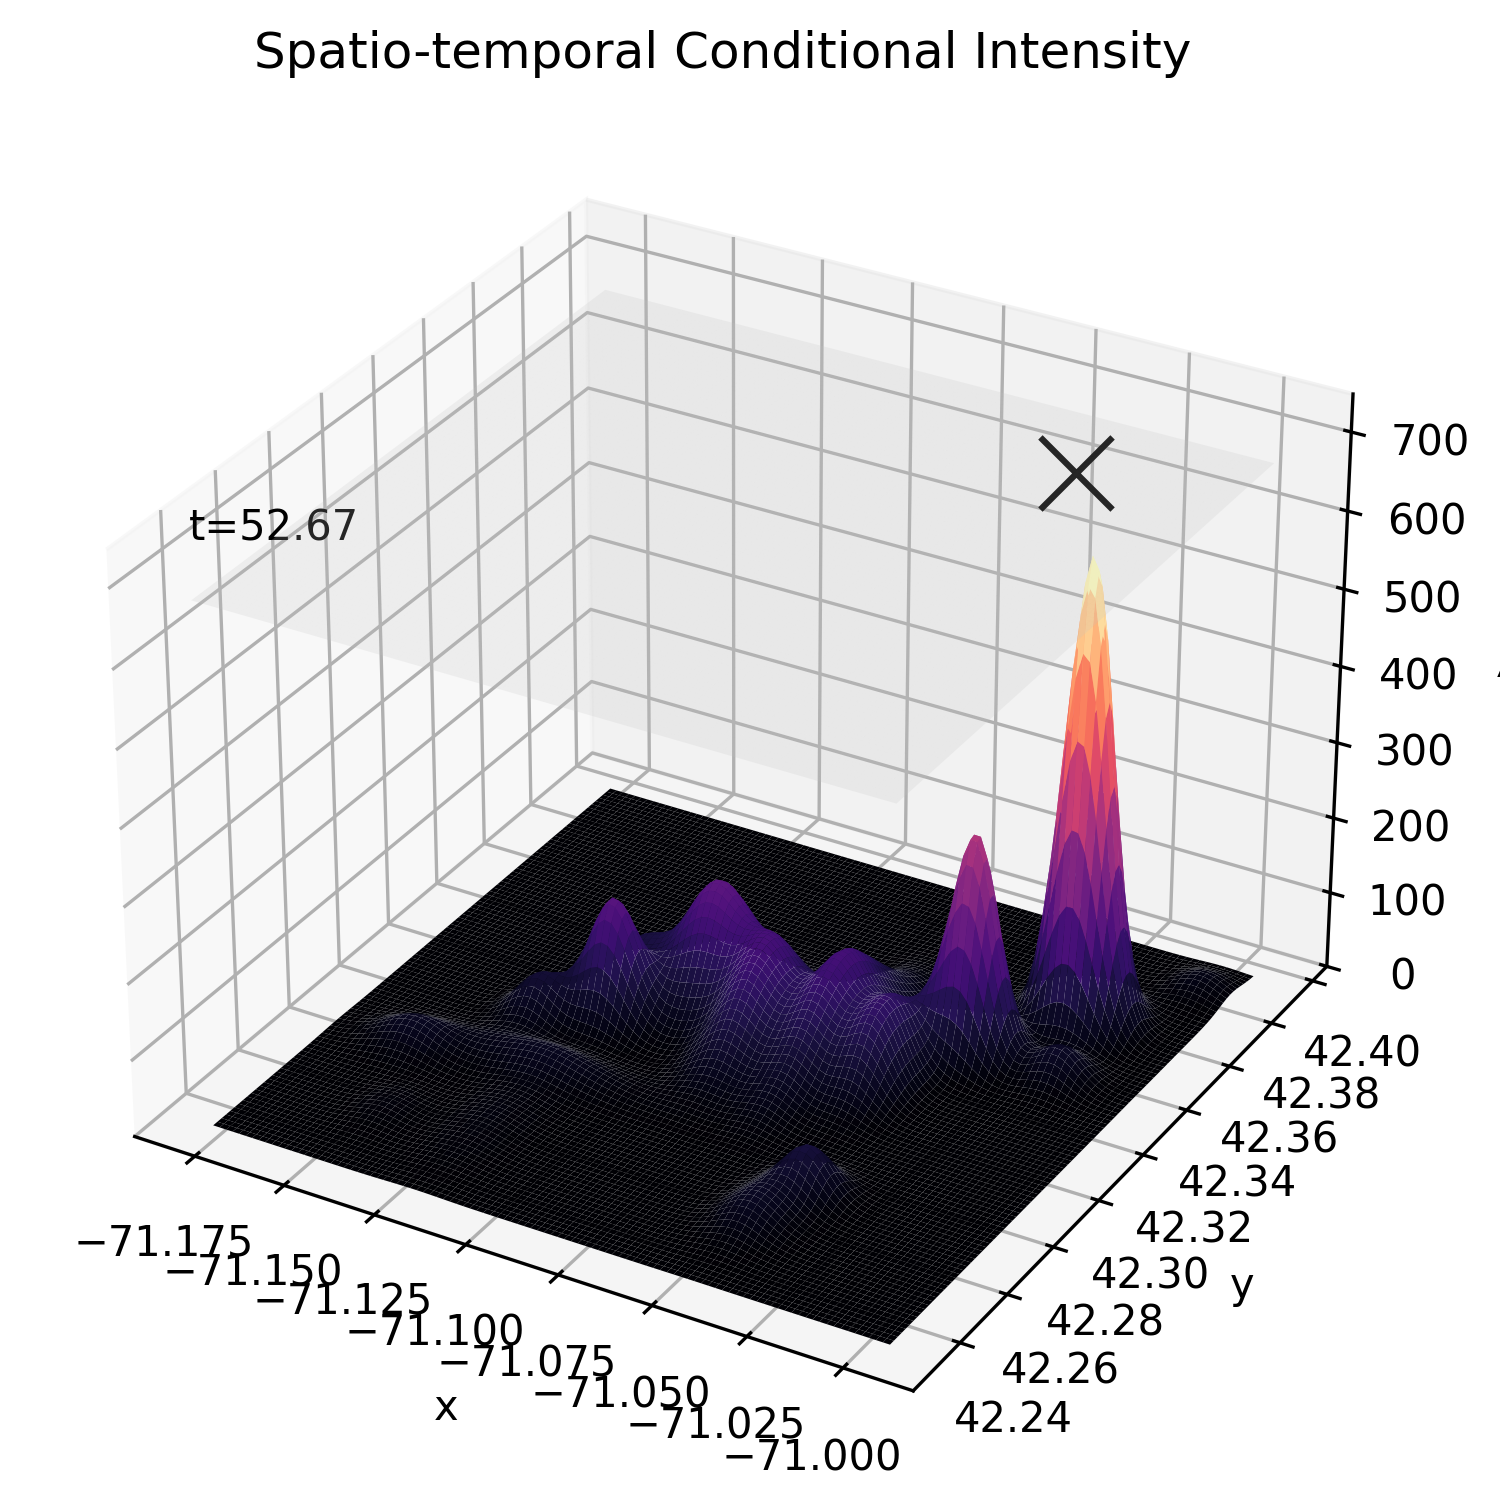

In [28]:
# Draw the spatio-temporal intensities
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10, 
                   scaler=None, fps=12, fn=f'video/{dataset}.mp4',draw_base_map=False)

In [30]:
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'models/{dataset}_{i}.mod', map_location=torch.device('cpu')))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

/tmp/ipykernel_22107/2114803108.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{dataset}_{i}.mod', map_location=torch.device('

4.9119 ± 0.0240
-1.7568 ± 0.0012


In [31]:
import folium
import numpy as np

# Example NumPy array of [lon, lat] pairs
coords = his_s

# Create a Folium map centered at the first coordinate
m = folium.Map(location=[coords[0, 1], coords[0, 0]], zoom_start=14)

# Add markers for each coordinate
for lon, lat in coords:
    folium.Marker(location=[lat, lon]).add_to(m)

# Display the map
#m


In [32]:
animate_lambs_on_map_smopy(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10, 
                   scaler=None, fps=12, fn=f'video/{dataset}_map_density_smopy.mp4')

Inferred cmax: 747.6328125





































































































201it [00:12, 16.18it/s]                         
